# Clone model

In [1]:
!git clone https://github.com/real2fish/CSL.git

Cloning into 'CSL'...
remote: Enumerating objects: 68, done.
remote: Counting objects: 100% (68/68), done.
remote: Compressing objects: 100% (65/65), done.
remote: Total 68 (delta 34), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (68/68), 197.21 KiB | 1.04 MiB/s, done.
Resolving deltas: 100% (34/34), done.


In [2]:
import sys
if not "CSL" in sys.path:
  sys.path += ["CSL"]

!cd CSL

In [3]:
# important if we want to replicate the findings in the paper
# particularly for notebooks like Colab.
import os

os.rename('/content/CSL/Multivariate_ts', './Multivariate_ts')

os.listdir()

['.config', 'Multivariate_ts', 'CSL', 'sample_data']

In [4]:
!git clone https://github.com/stephanielees/CSL_sales_cluster.git

Cloning into 'CSL_sales_cluster'...
remote: Enumerating objects: 18, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 18 (delta 4), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (18/18), 6.07 KiB | 6.07 MiB/s, done.
Resolving deltas: 100% (4/4), done.


## Installing dependent libraries

In [5]:
!pip install ucimlrepo
!pip install tsaug
!pip install tslearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 389.9/389.9 kB 9.6 MB/s eta 0:00:00


# Import libraries

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from CSL_sales_cluster.utils import ts_scatterplot, plot_dataset_in_clusters
import re
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import torch
from ucimlrepo import fetch_ucirepo
import tsaug
import CSL
from CSL import train, blocks, utils, CSL_AD, UEA

In [7]:
# reproduce the findings on the paper
# UEA.evaluate_UEA('BasicMotions')

# The use case data

In [8]:
sales_transactions_weekly = fetch_ucirepo(id=396)

# data (as pandas dataframes)
X = sales_transactions_weekly.data.features

In [9]:
X.shape

(811, 106)

In [10]:
X.columns[52:54]

Index(['MIN', 'MAX'], dtype='object')

In [11]:
X_norm = StandardScaler().fit_transform(X.iloc[:, :52])

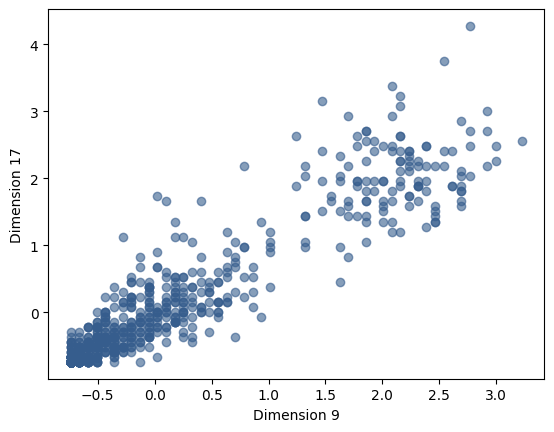

In [12]:
dim1 = 9
dim2 = 17
ts_scatterplot(X_norm, dim1, dim2)

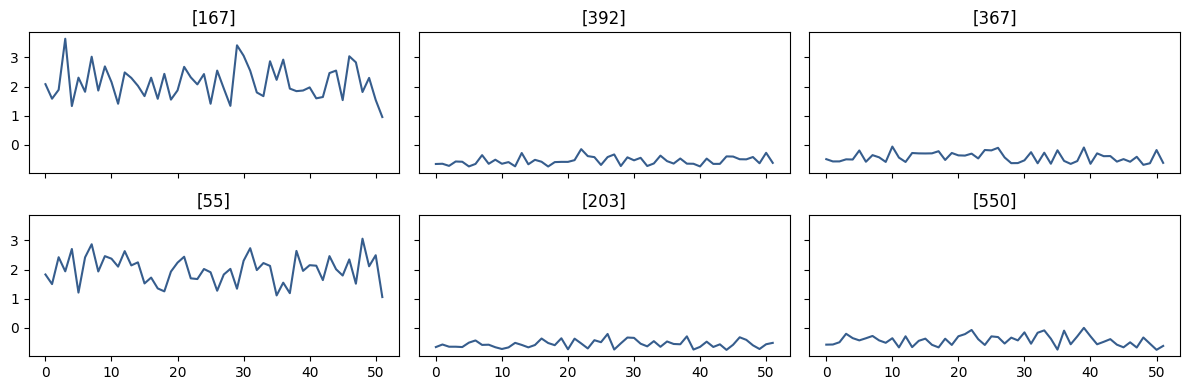

In [13]:
_, axs = plt.subplots(nrows=2, ncols=3, sharex=True, sharey=True, tight_layout=True, figsize=(12, 4))
rng = np.random.default_rng()
for i, ax in enumerate(axs.flat):
  item_id = rng.choice(811, 1)
  ax.plot(np.arange(52),
          X_norm[item_id].T,
          color='#365d8d')
  ax.set_title(item_id);

# Time series augmentation

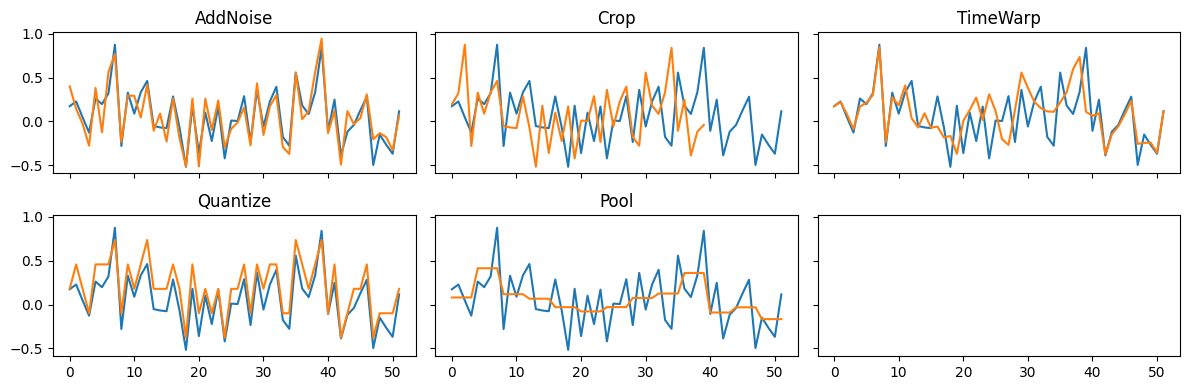

In [14]:
jitter = tsaug.AddNoise(loc=0.0, seed=1)
crop = tsaug.Crop(size=40, seed=1)
warp = tsaug.TimeWarp(seed=1)
quant = tsaug.Quantize(n_levels=5, seed=1)
pool = tsaug.Pool(size=4, seed=1)
pat = r'[A-Z][a-zA-Z]*'

_, axs = plt.subplots(nrows=2, ncols=3, sharex=True, sharey=True, tight_layout=True, figsize=(12, 4))
for ax, aug in zip(axs.flat, [jitter, crop, warp, quant, pool]):
  ax.plot(X_norm[0])
  ax.plot(aug.augment(X_norm[0]))
  ax.set_title(re.findall(pat, str(aug))[0]);

# Find shapelets with Contrastive Shapelet Learning

In [15]:
# X_norm = X_norm.to_numpy()
X_norm = np.expand_dims(X_norm, 1)
X_norm.shape

(811, 1, 52)

In [16]:
shapelets_length_v = {k:24 for k in np.linspace(0.1*X_norm.shape[2], 0.5*X_norm.shape[2], 8, dtype='int16')}
shapelets_length_v

{np.int16(5): 24,
 np.int16(8): 24,
 np.int16(11): 24,
 np.int16(14): 24,
 np.int16(17): 24,
 np.int16(20): 24,
 np.int16(23): 24,
 np.int16(26): 24}

In [17]:
csl = train.LearningShapeletsCL({5:24, 40:24},
                                loss_func=torch.nn.CrossEntropyLoss(), dist_measure='cosine',
                                num_classes=7, l3=0.5, l4=0.5, alpha=0.5,
                                verbose=1)

In [18]:
csl.set_optimizer(torch.optim.SGD(csl.model.parameters(), lr=1e-2))

In [19]:
csl.train(X_norm, batch_size=32, epochs=5)

Loss: [14.280557632446289, 0, 3.7421634197235107, 24.91405487060547, 0]: 100%|██████████| 5/5 [00:11<00:00,  2.25s/it]


[[19.244998931884766, 0, 12.724113464355469, 29.98835563659668, 0],
 [19.332523345947266, 0, 11.558387756347656, 29.820629119873047, 0],
 [19.367197036743164, 0, 10.384477615356445, 31.95701789855957, 0],
 [20.372142791748047, 0, 14.376802444458008, 31.412643432617188, 0],
 [18.805675506591797, 0, 10.622699737548828, 30.028995513916016, 0],
 [19.38120460510254, 0, 13.297504425048828, 28.89126205444336, 0],
 [18.930862426757812, 0, 13.077362060546875, 29.280902862548828, 0],
 [18.39834976196289, 0, 10.198652267456055, 29.5826416015625, 0],
 [18.687654495239258, 0, 10.992612838745117, 29.39501190185547, 0],
 [18.91652488708496, 0, 12.776666641235352, 29.440113067626953, 0],
 [17.582130432128906, 0, 7.778736114501953, 30.342973709106445, 0],
 [18.460363388061523, 0, 11.045279502868652, 29.97896957397461, 0],
 [20.216236114501953, 0, 13.505188941955566, 30.43763542175293, 0],
 [19.211843490600586, 0, 11.42089557647705, 30.389915466308594, 0],
 [19.779918670654297, 0, 12.750771522521973, 29

In [20]:
# to study the layers in the CSL model
csl.model

LearningShapeletsModel(
  (shapelets_blocks): ShapeletsDistBlocks(
    (blocks): ModuleList(
      (0-1): 2 x MaxCosineSimilarityBlock(
        (relu): ReLU()
      )
    )
  )
  (linear): Linear(in_features=48, out_features=7, bias=True)
  (projection): Sequential(
    (0): BatchNorm1d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (projection2): Sequential(
    (0): Linear(in_features=48, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
  )
)

In [21]:
X_transform = csl.transform(X_norm).numpy()
X_transform.shape

(811, 48)

In [22]:
X_norm.shape

(811, 1, 52)

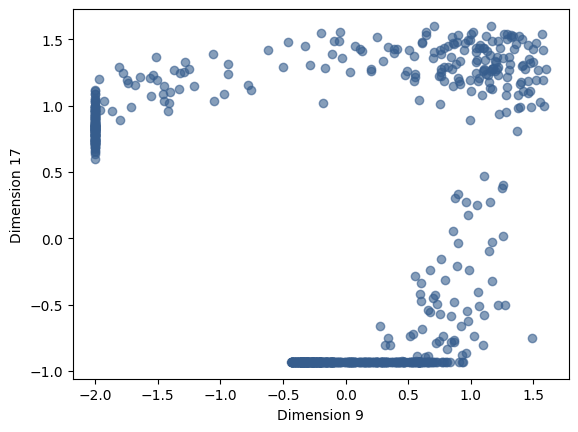

In [23]:
dim1 = 9
dim2 = 17

ts_scatterplot(X_transform, dim1, dim2)

# Clustering

In [24]:
from sklearn.cluster import KMeans, HDBSCAN

km = KMeans(n_clusters=3, random_state=1)
km.fit(X_transform)

hdb = HDBSCAN(metric='cosine')
hdb.fit(X_transform)

HDBSCAN(metric='cosine')

In [25]:
lab_km = km.predict(X_transform)
lab_hdb = hdb.labels_

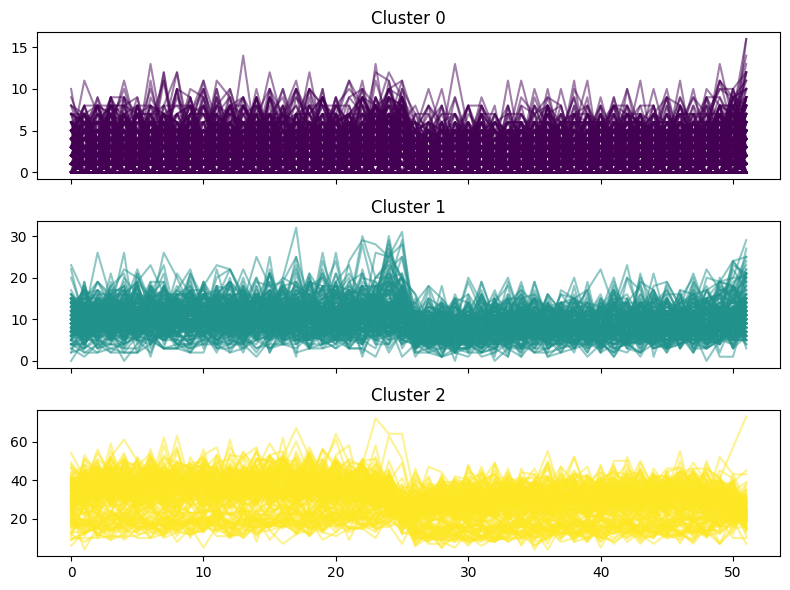

(array([0, 1, 2], dtype=int32), array([478, 170, 163]))

In [26]:
plot_dataset_in_clusters(X.iloc[:, :52].values, lab_km, sharey_=False, figsize=(8,6))
np.unique(lab_km, return_counts=True)

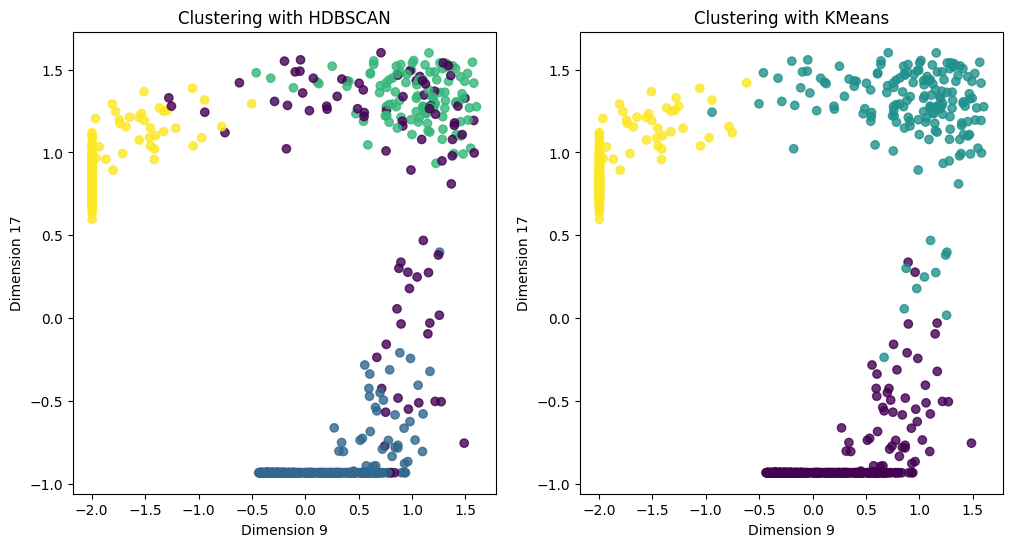

In [30]:
#plot the data in two dimensions
dim1 = 9
dim2 = 17
_, axs = plt.subplots(1, 2, figsize=(12, 6))
for ax, label_arr, label_name in zip(axs, [lab_hdb, lab_km], ['HDBSCAN', 'KMeans']):
  ax.scatter(X_transform[:, dim1], X_transform[:, dim2], c=label_arr, cmap='viridis', alpha=0.8)
  ax.set_xlabel(f'Dimension {dim1}')
  ax.set_ylabel(f'Dimension {dim2}')
  ax.set_title(f'Clustering with {label_name}');

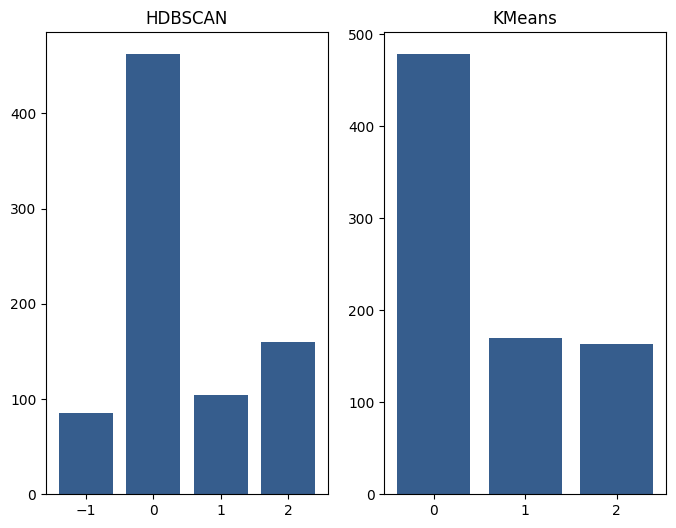

In [28]:
class_label_km, counts_km = np.unique(lab_km, return_counts=True)
class_label_hdb, counts_hdb = np.unique(lab_hdb, return_counts=True)
_, axs = plt.subplots(1, 2, figsize=(8, 6))
axs[0].bar(class_label_hdb, counts_hdb, color='#365d8d')
axs[0].set_title('HDBSCAN')
axs[1].bar(class_label_km, counts_km, color='#365d8d')
axs[1].set_title('KMeans');

In [29]:
print(silhouette_score(X_transform, lab_km, metric='cosine'))
mask = lab_hdb != -1
print(silhouette_score(X_transform[mask], lab_hdb[mask], metric='cosine'))

0.7821468
0.8253352
